## Budget Calculator App API

This notebook serves as a model for the app API

In [55]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from io import StringIO

## Initial Requests 

This code runs each time the application starts. 

In [56]:
base_url = 'https://www.numbeo.com/cost-of-living/historical-data-city-selector'

In [57]:
page = requests.get(base_url)
numbeo_city_soup = BeautifulSoup(page.content, "html.parser")
results = numbeo_city_soup.find('table', class_='related_links')

In [58]:
list_cities = results.find_all('a')
list_cities[0]

<a href="https://www.numbeo.com/cost-of-living/city-history/in/%27s-Hertogenbosch">'s-Hertogenbosch, Netherlands</a>

In [59]:
city_name = lambda x: f"{x[0]} ({x[1].strip()})" if len(x) > 2 else x[0]

city_dict = lambda x: {'City':city_name(x.text.split(",")), 'Country':x.text.split(",")[-1].strip(), 'Url':x["href"]}
city_pages = [city_dict(city) for city in list_cities]

In [60]:
df = pd.DataFrame(city_pages) # creates a dataframe with all cities, their country and page urls for their data tables 
df.head()

,City,Country,Url
0,'s-Hertogenbosch,Netherlands,https://www.numbeo.com/cost-of-living/city-his...
1,Aachen,Germany,https://www.numbeo.com/cost-of-living/city-his...
2,Aalborg,Denmark,https://www.numbeo.com/cost-of-living/city-his...
3,Aarhus,Denmark,https://www.numbeo.com/cost-of-living/city-his...
4,Abbotsford,Canada,https://www.numbeo.com/cost-of-living/city-his...


## User Interaction

This part of the code kicks in when the user inputs search criterion via the UI. Country and city are case sensitive. Appropriate measures should be taken in the app logic to prevent link brakage due to incorrect user entries.

In [61]:
country_selection = input("Select Country")
country_slice = df[df["Country"] == country_selection]

In [62]:
country_slice

,City,Country,Url
192,Cape Town,South Africa,https://www.numbeo.com/cost-of-living/city-his...
294,Durban,South Africa,https://www.numbeo.com/cost-of-living/city-his...
450,Johannesburg,South Africa,https://www.numbeo.com/cost-of-living/city-his...
763,Port Elizabeth,South Africa,https://www.numbeo.com/cost-of-living/city-his...
777,Pretoria,South Africa,https://www.numbeo.com/cost-of-living/city-his...


Once the data has been sliced by country, the user can select a city. Some cities are duplicated accross countries or states. Being able to avoid ambiguity by defining country then city is an essential step in ensuring the app provides accurate information.

In [63]:
def get_tables(city):
    page = requests.get(df.iloc[df.loc[df['City'] == city].index[0]]["Url"])
    one_city_soup = BeautifulSoup(page.content, "html.parser")
    inner_width = one_city_soup.find_all('div', class_='innerWidth')
    results = inner_width[2].find_all('table')
    return results

In [64]:
city = input("Enter City")
data = get_tables(city)

In [65]:
len(data)


14

A total of 14 tables are returned. 



The below function `converts the raw html tables into dataframes`. 
The dataframes are then combined into categories of cost groups which the user will be able to track their expenditure in.

The categories that will be tracked on our application include: 

- The cost of restuarant outings
- The cost of food and grocery items 
- Monthly rental expenses 
- Monthly transport expenses
- Monthly cost of utilities
- Montly expenditure on sports and leisure
- Monthly expenditure on clothing

In [66]:
def categorize_data(tables):
    """Categorize and process data from a list of tables."""
    # Convert each table in the list to DataFrame
    reader_converter = lambda x: pd.DataFrame(pd.read_html(StringIO(str(x)))[0])
    df_list = [reader_converter(table) for table in tables]

    # Categorize different types of data
    restaurants = pd.concat([df_list[0], df_list[1]], axis=1).T.drop_duplicates().T
    markets = pd.concat([df_list[2], df_list[3], df_list[4]], axis=1).T.drop_duplicates().T
    transport = pd.concat([df_list[8], df_list[9]], axis=1).T.drop_duplicates().T
    rent = df_list[5]
    utilities = df_list[11]
    leisure = df_list[12]
    clothing = df_list[13]

    # Collect categorized frames into a list
    categorized_frames = {
        'restaurants': restaurants,
        'markets': markets,
        'leisure': leisure,
        'rent': rent,
        'transport': transport,
        'utilities': utilities,
        'clothing': clothing
    }

    return categorized_frames

In [67]:
categorized_frames = categorize_data(data)

In [68]:
categorized_frames['transport'].head()

,Year,One-way Ticket (Local Transport),Gasoline (1 liter),Monthly Pass (Regular Price)
0,2024,18.22,23.03,-
1,2023,18.44,23.09,735.56
2,2022,21.62,22.41,609.42
3,2021,22.83,17.56,505.80
4,2020,17.67,15.27,551.42


The below function cleans the categorized data, removing nulls and changing datatypes to floats. This is essential for the next step: interpolation. Interpolation fills in null values according to a prescribed pattern ("linear" in this case) ensuring continuity and userbility in the data.  

In [69]:
import numpy as np
import pandas as pd

def clean_data(frames):
    new_frames = []
    for frame in list(frames.values()):
        # Step 1: Identify columns to interpolate excluding 'Year'
        interpolate_columns = frame.columns[frame.columns != 'Year']

        # Step 2: Extract the subset of data to interpolate
        data_to_interpolate = frame[interpolate_columns].replace(to_replace="-", value=np.nan)

        # Step 3: Perform interpolation
        # First, fill NaNs with forward fill, then backward fill if still NaNs exist
        interpolated_data = data_to_interpolate.astype(float).fillna(method='ffill').fillna(method='bfill')

        # Step 4: Replace the original columns with interpolated data
        frame[interpolate_columns] = interpolated_data

        # Step 5: Append the modified frame to the list of new frames
        new_frames.append(frame)
        
    return new_frames



In [70]:
clean_data = clean_data(categorized_frames)

/var/folders/dt/53bpx70s19ndyhz8nj3phw1h0000gn/T/ipykernel_39438/1535557813.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_to_interpolate = frame[interpolate_columns].replace(to_replace="-", value=np.nan)
/var/folders/dt/53bpx70s19ndyhz8nj3phw1h0000gn/T/ipykernel_39438/1535557813.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_data = data_to_interpolate.astype(float).fillna(method='ffill').fillna(method='bfill')
/var/folders/dt/53bpx70s19ndyhz8nj3phw1h0000gn/T/ipykernel_39438/1535557813.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call 

In [71]:
clean_data[4].head()

,Year,One-way Ticket (Local Transport),Gasoline (1 liter),Monthly Pass (Regular Price)
0,2024,18.22,23.03,735.56
1,2023,18.44,23.09,735.56
2,2022,21.62,22.41,609.42
3,2021,22.83,17.56,505.80
4,2020,17.67,15.27,551.42


Once interpolated, the data can be ploted as a time series (line plot showing values from 2011 to 2023 for each feature).

In [72]:
titles = ["restaurants", "markets", "leisure", "rent", "transport", "utilities", "clothing"]
records = {title: df.to_dict(orient='records') for title, df in zip(titles, clean_data)}

In [73]:
def plot_trend_visual(data, category):
    import matplotlib.pyplot as plt
    import numpy as np
    years = [entry['Year'] for entry in data]
    labels = list(data[0].keys())[1:]  # All keys except 'Year'

    # Prepare a plot
    plt.figure(figsize=(12, 6))

    # Plot each meal type
    for label in labels:
        prices = [entry[label] for entry in data]
        plt.plot(years, prices, marker='o', label=label)

    # Customize the plot
    plt.title(f'Price Trends of Various {category} Over Years in {city}, {country_selection}')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.xticks(years)  # Set x-ticks to be each year
    plt.legend(title=category)
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [74]:
records["restaurants"][0]

{'Year': 2024,
 'Meal, Inexpensive Restaurant': 177.29,
 'Meal for 2 People, Mid-range Restaurant, Three-course': 706.94,
 'McMeal at McDonalds (or Equivalent Combo Meal)': 89.16,
 'Domestic Beer (0.5 liter draught)': 48.9,
 'Imported Beer (0.33 liter bottle)': 50.0,
 'Coke/Pepsi (0.33 liter bottle)': 18.91,
 'Water (0.33 liter bottle)': 13.85,
 'Cappuccino (regular)': 36.33}

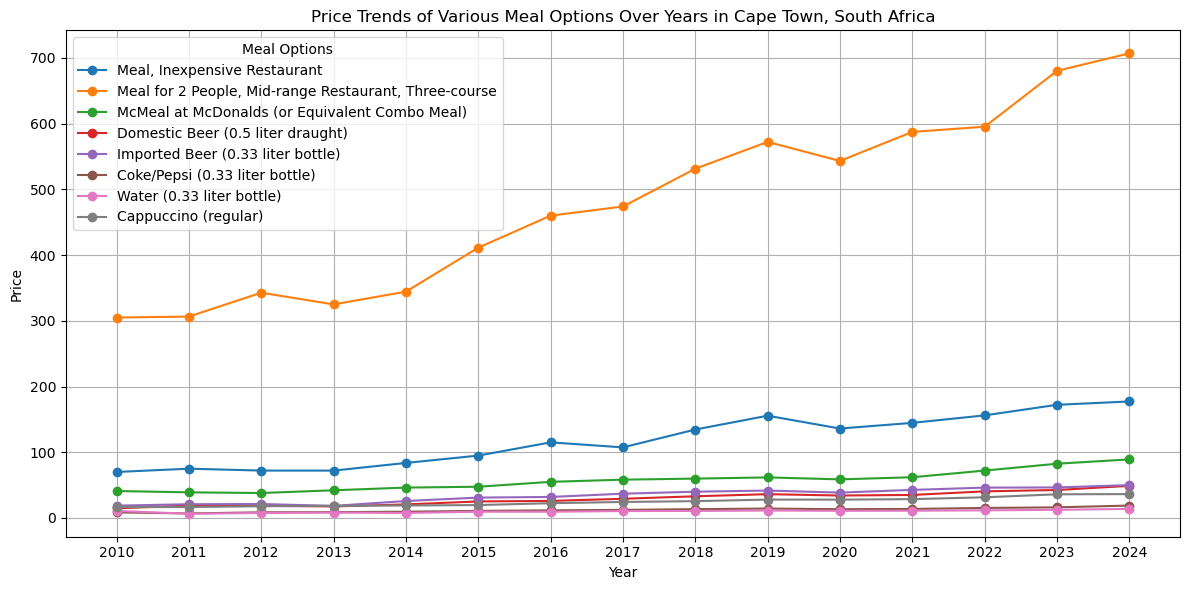

In [75]:
plot_trend_visual(records["restaurants"], 'Meal Options')

In [76]:
records["markets"][0]

{'Year': 2024,
 'Milk (regular), (1 liter)': 19.66,
 'Loaf of Fresh White Bread (500g)': 19.14,
 'Eggs (regular) (12)': 45.27,
 'Water (1.5 liter bottle)': 16.7,
 'Domestic Beer (0.5 liter bottle)': 24.69,
 'Imported Beer (0.33 liter bottle)': 29.16,
 'Apples (1kg)': 27.66,
 'Oranges (1kg)': 27.27,
 'Potato (1kg)': 20.7,
 'Lettuce (1 head)': 19.63,
 'Rice (white), (1kg)': 30.71,
 'Tomato (1kg)': 27.63,
 'Banana (1kg)': 27.64,
 'Onion (1kg)': 22.12,
 'Local Cheese (1kg)': 145.65,
 'Bottle of Wine (Mid-Range)': 94.55,
 'Cigarettes 20 Pack (Marlboro)': 52.31,
 'Chicken Fillets (1kg)': 88.8,
 'Beef Round (1kg) (or Equivalent Back Leg Red Meat)': 131.5}

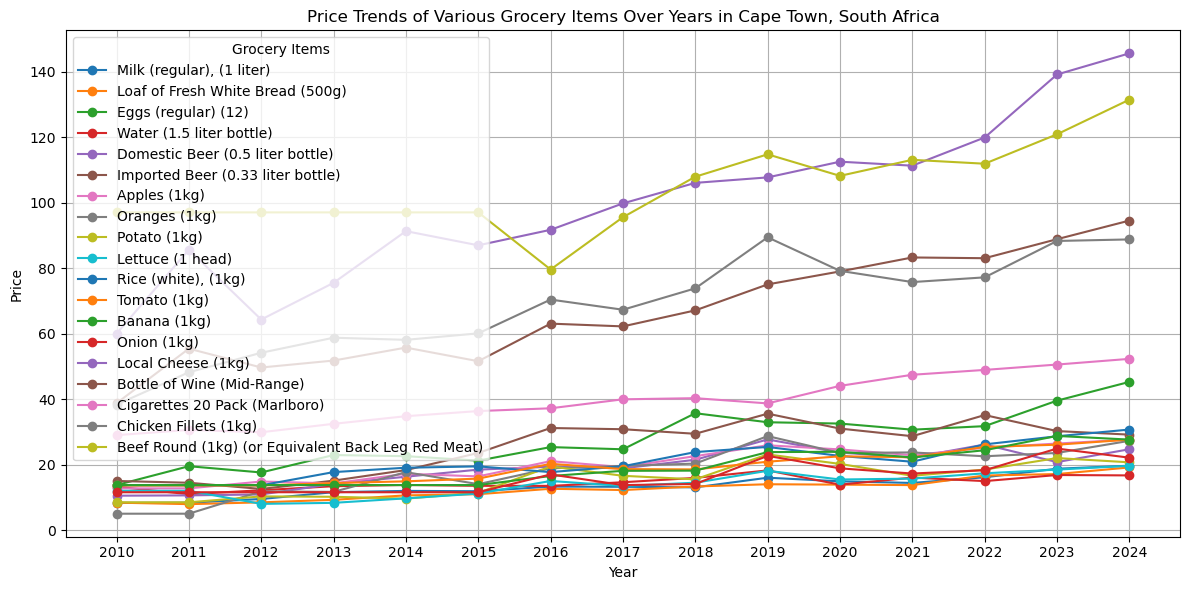

In [77]:
plot_trend_visual(records["markets"], 'Grocery Items')

In [78]:
records["leisure"][0]

{'Year': 2024,
 'Fitness Club, Monthly Fee for 1 Adult': 727.2,
 'Tennis Court Rent (1 Hour on Weekend)': 171.43,
 'Cinema, International Release, 1 Seat': 116.5}

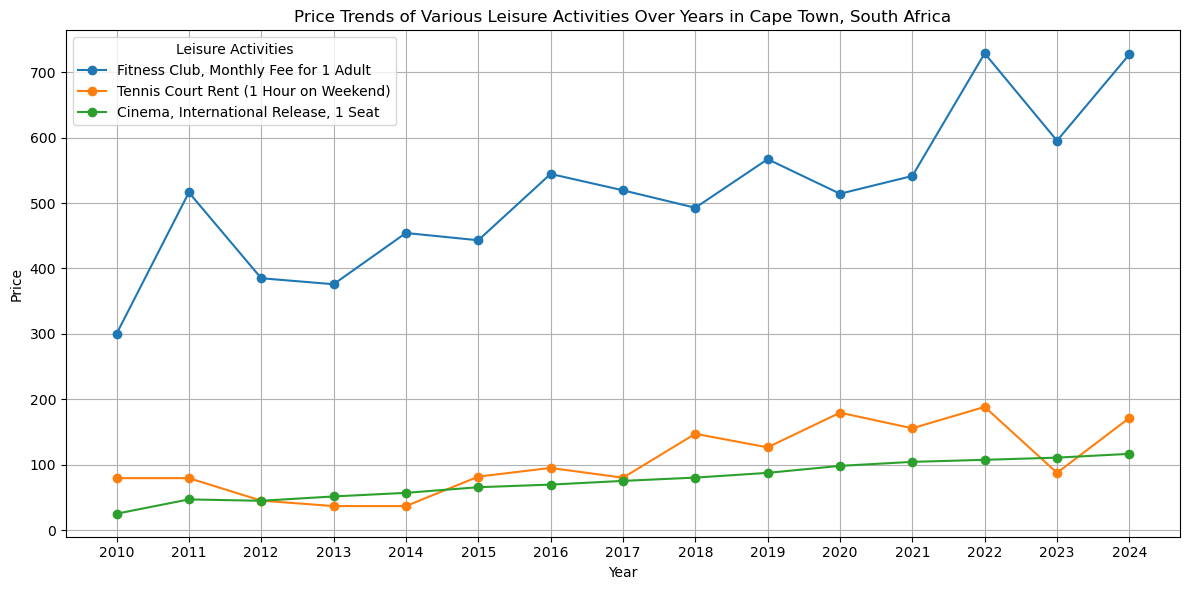

In [79]:
plot_trend_visual(records["leisure"], 'Leisure Activities')

In [98]:
records["rent"][0]

{'Year': 2024,
 'Apartment (1 bedroom) in City Centre': 14033.33,
 'Apartment (1 bedroom) Outside of Centre': 9150.0,
 'Apartment (3 bedrooms) in City Centre': 28481.48,
 'Apartment (3 bedrooms) Outside of Centre': 18746.67}

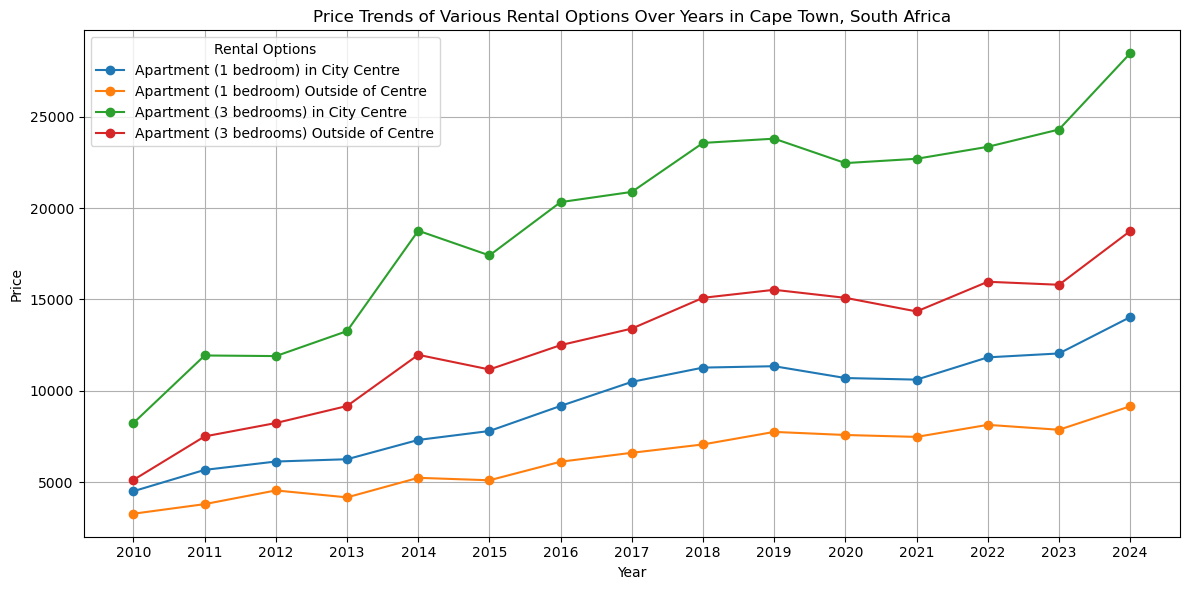

In [81]:
plot_trend_visual(records["rent"], 'Rental Options')

In [82]:
records["transport"][0]

{'Year': 2024,
 'One-way Ticket (Local Transport)': 18.22,
 'Gasoline (1 liter)': 23.03,
 'Monthly Pass (Regular Price)': 735.56}

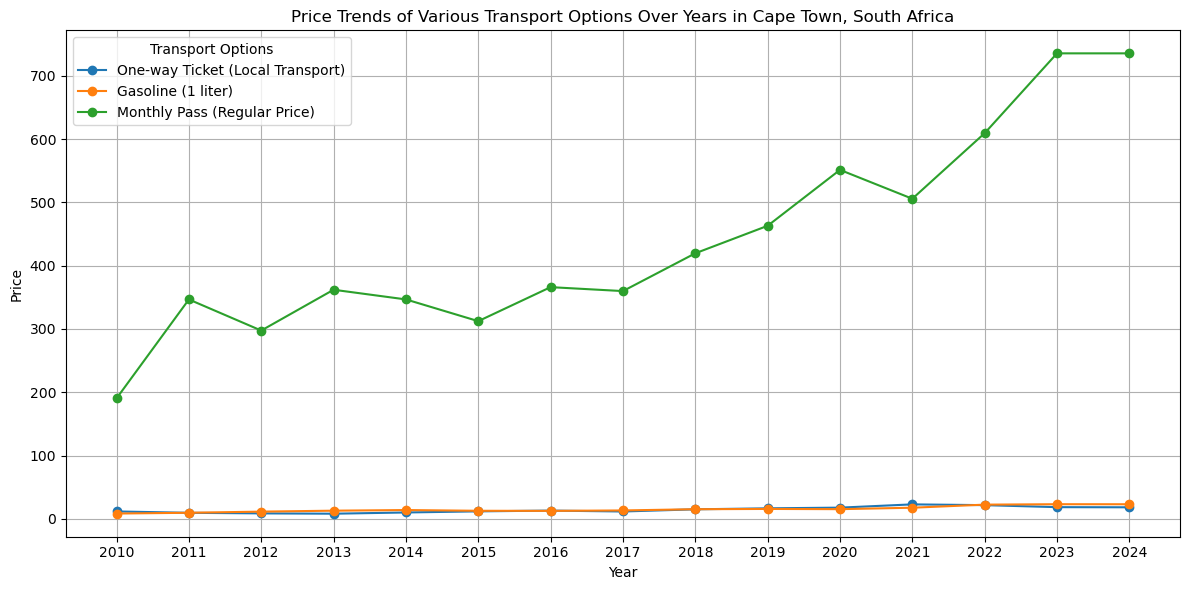

In [83]:
plot_trend_visual(records["transport"], 'Transport Options')

In [84]:
records["utilities"][0]

{'Year': 2024,
 'Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment': 1761.93,
 'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)': 746.38,
 'Mobile Phone Monthly Plan with Calls and 10GB+ Data': 543.46}

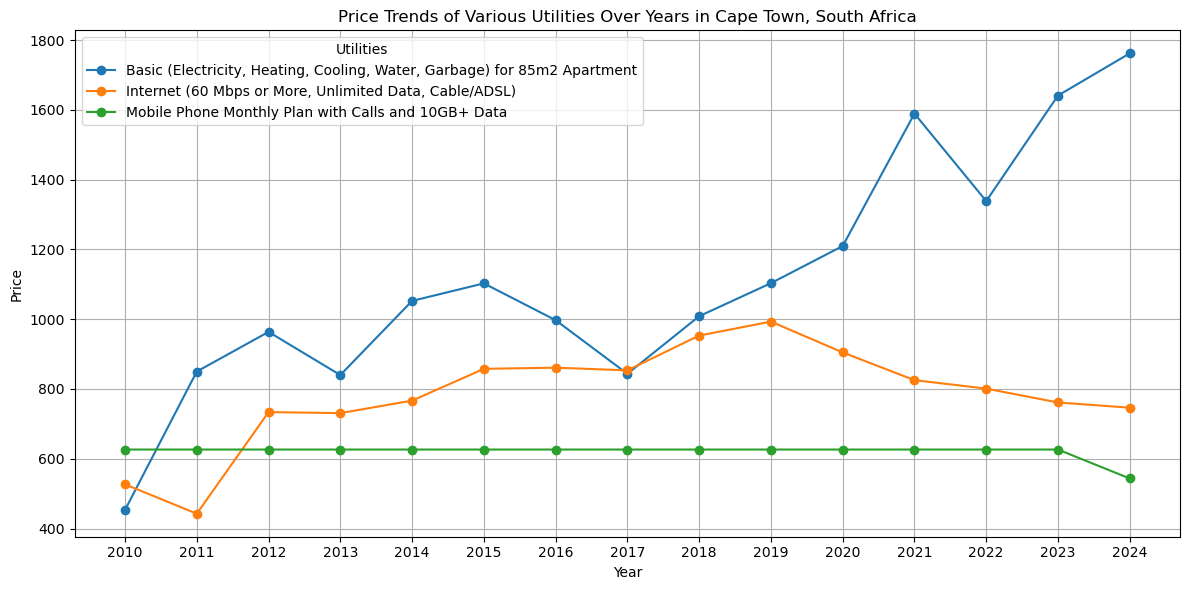

In [85]:
plot_trend_visual(records["utilities"], 'Utilities')

In [86]:
records["clothing"][0]

{'Year': 2024,
 '1 Pair of Jeans (Levis 501 Or Similar)': 952.52,
 '1 Summer Dress in a Chain Store (Zara, H&M, ...)': 557.4,
 '1 Pair of Nike Running Shoes (Mid-Range)': 1932.76,
 '1 Pair of Men Leather Business Shoes': 1440.38}

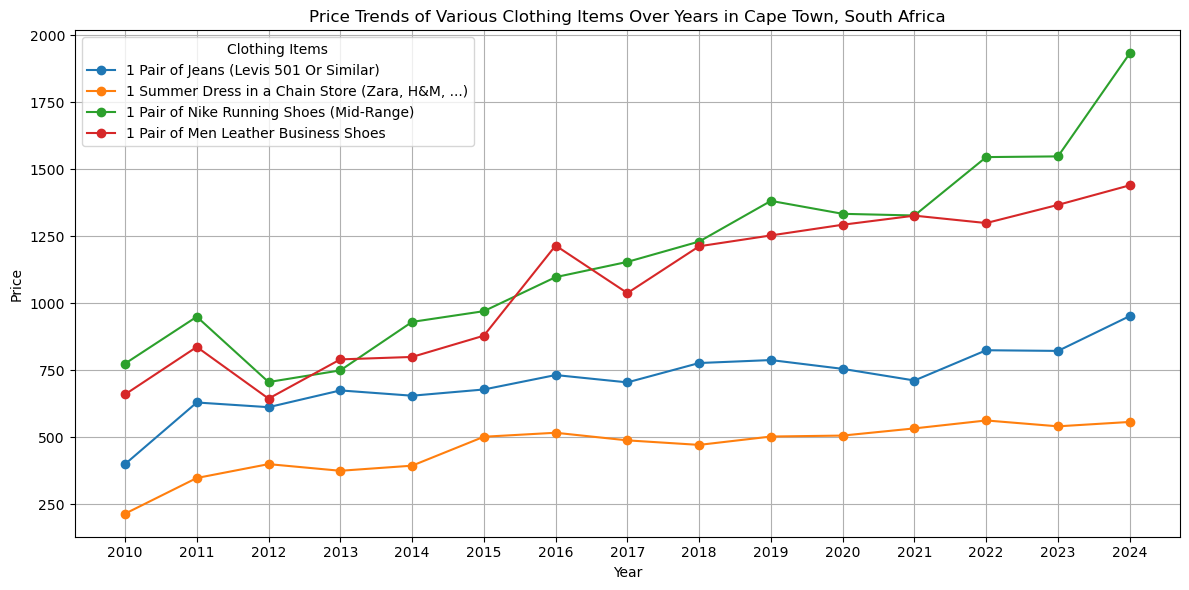

In [87]:
plot_trend_visual(records["clothing"], 'Clothing Items')

## Helper Functions

#### Restaurants Estimate

In [88]:
restaurants = clean_data[0]
est_restaurant = round(restaurants.iloc[0:1,1:5].sum().sum(), 2)
est_restaurant

np.float64(1022.29)

#### Market Estimate

In [89]:
market = clean_data[1]
est_market = round(market.iloc[0:1,1:].sum().sum() * 2, 2)
est_market

np.float64(1741.58)

#### Leisure Average

In [90]:
leisure = clean_data[2]
est_leisure = round(leisure.iloc[0:1,1:].sum().sum(), 2)
est_leisure

np.float64(1015.13)

#### Rental Average

In [91]:
rental = clean_data[3]
est_rent = round((rental.iloc[0:1,1:3].sum().mean() + rental.iloc[0:1,3:].sum().mean() / 3) / 2, 2)
est_rent

np.float64(9731.51)

#### Public Transport 

In [92]:
transport = clean_data[4]
est_transport = round((
    transport.iloc[0:1,3:].sum().sum() + 
    transport.iloc[0:1,2:3].sum().sum() * 30 + 
    transport.iloc[0:1,1:2].sum().sum() * 44 ) / 3, 2)
est_transport 

np.float64(742.71)

#### Utilites 

In [93]:
utilities = clean_data[5]
est_utilities = round(utilities.iloc[0:1,1:].sum().sum() / 2, 2)
est_utilities 

np.float64(1525.88)

#### Clothing

In [94]:
clothing = clean_data[6]

est_clothing = round((clothing.iloc[0:1:,1:2].sum().sum() * 4 +
    clothing.iloc[0:1,2:3].sum().sum() * 12 +
    clothing.iloc[0:1,3:4].sum().sum() * 2 +
    clothing.iloc[0:1,4:].sum().sum() * 2
) / 12, 2)

est_clothing

np.float64(1437.1)

In [95]:
total = sum([est_rent, est_restaurant, est_market, est_leisure, est_transport, est_clothing, est_utilities])
round(total, 2)

np.float64(17216.2)

In [96]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
import os

def save_df(df_list, city): 
    categories=["Market","Leisure","Rental","Transport", "Utilities","Clothing"]
    # Create directory if it doesn't exist
    directory = f'data/processed/{city}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    for index, frame in enumerate(df_list):
        # Ensure the title index is within bounds
        frame.astype(float).interpolate()
        if index < len(categories):
            # Save DataFrame to CSV
            frame.to_csv(f'{directory}/{categories[index]}.csv', sep=',', index=False, encoding='utf-8')

In [ ]:
save_df(clean_data, 'nairobi')
